### Imports

In [39]:
import os
import tensorflow as tf

# Set environment variable to suppress logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dropout, Dense, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
)
from tensorflow.keras.callbacks import EarlyStopping
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
import re

In [8]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

### Preprocessing

In [9]:
# Load datasets
true_df = pd.read_csv("News-_dataset/True.csv")
fake_df = pd.read_csv("News-_dataset/Fake.csv")

# Add labels
true_df['label'] = 1
fake_df['label'] = 0

# Combine and shuffle
df = pd.concat([true_df, fake_df], axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [10]:
# Drop nulls and duplicates
df.dropna(inplace=True)
df.drop_duplicates(subset=["title", "text"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39105 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    39105 non-null  object
 1   text     39105 non-null  object
 2   subject  39105 non-null  object
 3   date     39105 non-null  object
 4   label    39105 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


In [11]:
# Combine title and text
df['content'] = df['title'] + " " + df['text']
df.drop(columns=["title", "text", "date"], inplace=True)

df.head()

,subject,label,content
0,News,0,BREAKING: GOP Chairman Grassley Has Had Enoug...
1,News,0,Failed GOP Candidates Remembered In Hilarious...
2,News,0,Mike Pence’s New DC Neighbors Are HILARIOUSLY...
3,politicsNews,1,California AG pledges to defend birth control ...
4,politics,0,AZ RANCHERS Living On US-Mexico Border Destroy...


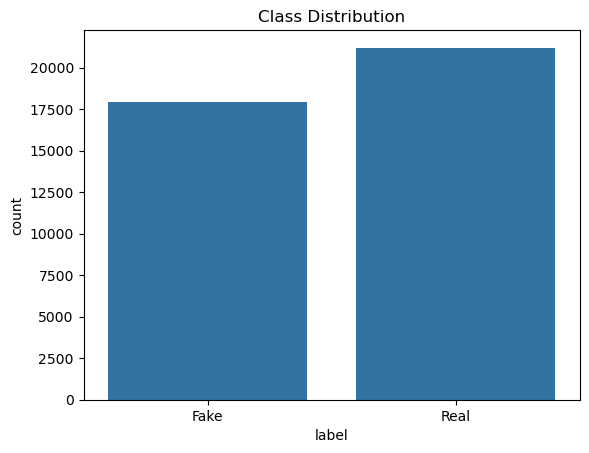

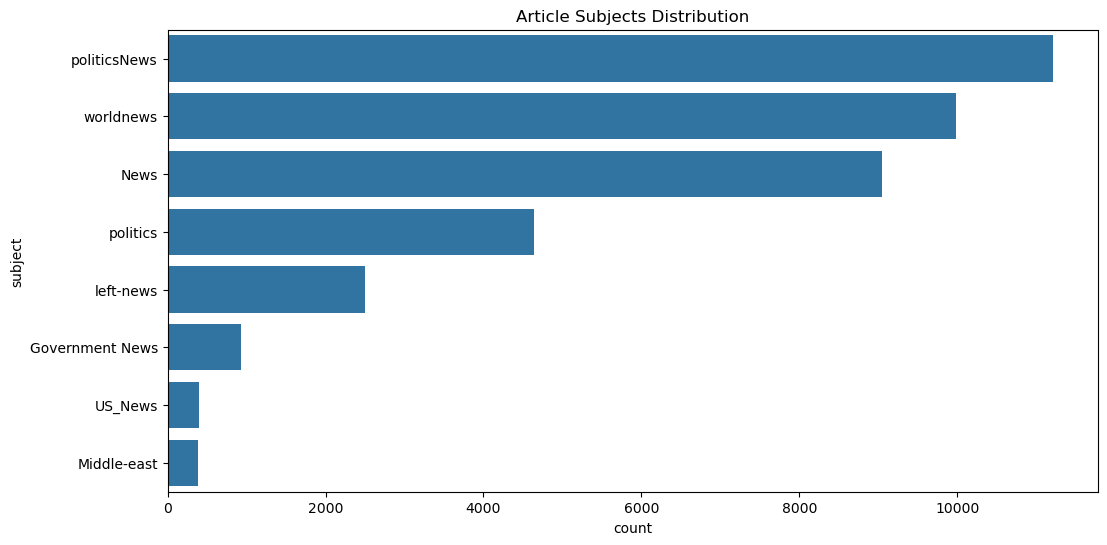

In [12]:
# Class distribution
sns.countplot(data=df, x='label')
plt.title("Class Distribution")
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

# Subjects distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='subject', order=df['subject'].value_counts().index)
plt.title("Article Subjects Distribution")
plt.show()


In [13]:
df_copy = df.copy(deep=True)

In [14]:
df = df_copy.copy(deep=True)
def clean_text(text):
    # Remove "(Reuters) - " and similar patterns *anywhere* in the text
    text = re.sub(r'\b\w+\s+\(?Reuters\)?\s*-\s+', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\(?Reuters\)?\s*-\s+', '', text, flags=re.IGNORECASE)

    # Identify last sentence using rpartition (better precision)
    text = text.strip()
    last_dot_idx = text.rstrip().rfind('.')  # find last period

    if last_dot_idx != -1:
        before_last, sep, last_sentence = text.rpartition('.')
        if re.search(r'\b(images?|capture|featured|via)\b', last_sentence, re.IGNORECASE):
            text = before_last + '.'  # keep everything before last sentence
        else:
            text = before_last + '.' + last_sentence  # nothing to remove
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # Remove non-letter characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Lowercase and strip extra spaces
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Apply to the merged title + text content
df['clean_content'] = df['content'].apply(clean_text)



🔷 Original [32164]:
ization, and passing the proposed TPP,” Navarro and Gray wrote.  “These deals only weaken our manufacturing base and ability to defend ourselves and our allies.” Trump has vowed to pull the United States out of the TPP, a free-trade pact aimed at linking a dozen Pacific Rim nations that President Barack Obama signed in February. It has not been ratified by the U.S. Senate.  The president-elect has also vowed to renegotiate the NAFTA pact with Canada and Mexico, saying it had cost American jobs. 

✅ Cleaned  [32164]:
e world trade organization and passing the proposed tpp navarro and gray wrote these deals only weaken our manufacturing base and ability to defend ourselves and our allies trump has vowed to pull the united states out of the tpp a freetrade pact aimed at linking a dozen pacific rim nations that president barack obama signed in february it has not been ratified by the us senate the presidentelect has also vowed to renegotiate the nafta pact with canada 

/tmp/ipykernel_11817/3313189497.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['raw_len'], label='Original Content', shade=True)
/tmp/ipykernel_11817/3313189497.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['clean_len'], label='Cleaned Content', shade=True)


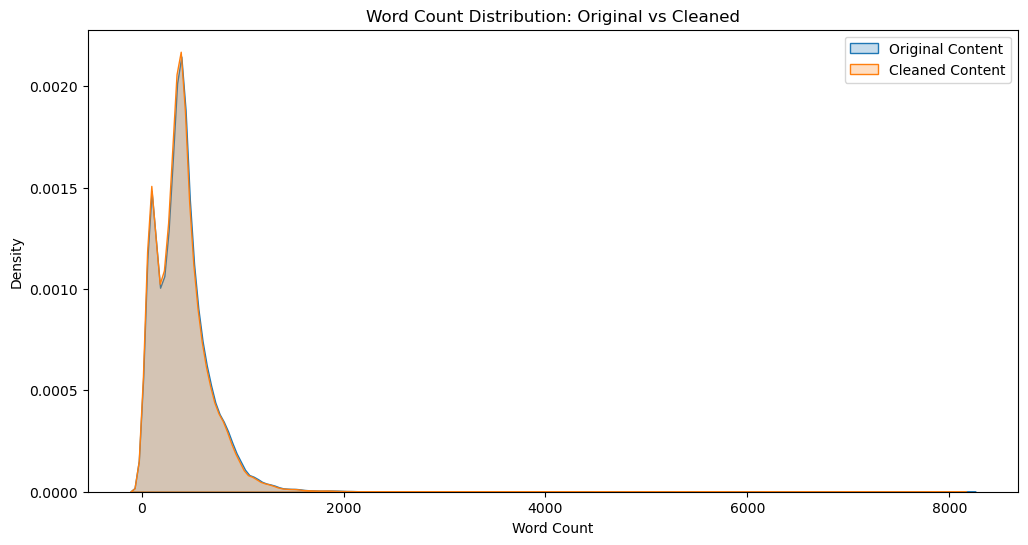

In [15]:
# Show side-by-side comparison of raw vs cleaned content
comparison_df = df[['content', 'clean_content']].sample(50, random_state=42)
for i, row in comparison_df.iterrows():
    # print(f"\n🔷 Original [{i}]:\n{row['content'][:500]}")
    # print(f"\n✅ Cleaned  [{i}]:\n{row['clean_content'][:500]}")
    # print("="*100)
    print(f"\n🔷 Original [{i}]:\n{row['content'][-500:]}")
    print(f"\n✅ Cleaned  [{i}]:\n{row['clean_content'][-500:]}")
    print("="*100)

# Compute length differences
df['raw_len'] = df['content'].apply(lambda x: len(x.split()))
df['clean_len'] = df['clean_content'].apply(lambda x: len(x.split()))
df['reduction'] = df['raw_len'] - df['clean_len']

# Print average reduction
print(f"\n📉 Average word count reduction: {df['reduction'].mean():.2f} words per article")

# Visualize word count distributions
plt.figure(figsize=(12, 6))
sns.kdeplot(df['raw_len'], label='Original Content', shade=True)
sns.kdeplot(df['clean_len'], label='Cleaned Content', shade=True)
plt.title("Word Count Distribution: Original vs Cleaned")
plt.xlabel("Word Count")
plt.legend()
plt.show()


In [16]:
import numpy as np
from statistics import mode, StatisticsError

# Calculate word counts for each article
df['word_count'] = df['clean_content'].apply(lambda x: len(x.split()))

# Compute statistics
avg_words = df['word_count'].mean()
max_words = df['word_count'].max()
min_words = df['word_count'].min()
median_words = df['word_count'].median()

try:
    mode_words = mode(df['word_count'])
except StatisticsError:
    mode_words = "No unique mode"

# Display results
print(f"📊 Word Count Stats in `clean_content`:")
print(f"Average: {avg_words:.2f} words")
print(f"Maximum: {max_words} words")
print(f"Minimum: {min_words} words")
print(f"Median: {median_words} words")
print(f"Mode: {mode_words}")

📊 Word Count Stats in `clean_content`:
Average: 402.01 words
Maximum: 8057 words
Minimum: 0 words
Median: 370.0 words
Mode: 404


In [17]:
print(f"✅ Cleaned DataFrame shape: {df.shape}")

✅ Cleaned DataFrame shape: (39105, 8)


In [18]:
# Recalculate word count in case it's outdated
df['word_count'] = df['clean_content'].apply(lambda x: len(x.split()))

# Get indexes where word count is 6 or less
zero_word_indexes = df[df['word_count'] <= 6].index.tolist()

# Display
print(f"🧾 Total rows with 6 words or less: {len(zero_word_indexes)}")
print(f"Indexes: {zero_word_indexes}")


🧾 Total rows with 6 words or less: 9
Indexes: [24, 11343, 13493, 13550, 16730, 18327, 18825, 26511, 40247]


In [19]:
# Drop rows where word count is less than or equal to 6
df = df[df['word_count'] > 6].reset_index(drop=True)

print(f"✅ Cleaned DataFrame shape: {df.shape}")

✅ Cleaned DataFrame shape: (39096, 8)


In [20]:
import numpy as np
from statistics import mode, StatisticsError

# Calculate word counts for each article
df['word_count'] = df['clean_content'].apply(lambda x: len(x.split()))

# Compute statistics
avg_words = df['word_count'].mean()
max_words = df['word_count'].max()
min_words = df['word_count'].min()
median_words = df['word_count'].median()

try:
    mode_words = mode(df['word_count'])
except StatisticsError:
    mode_words = "No unique mode"

# Display results
print(f"📊 Word Count Stats in `clean_content`:")
print(f"Average: {avg_words:.2f} words")
print(f"Maximum: {max_words} words")
print(f"Minimum: {min_words} words")
print(f"Median: {median_words} words")
print(f"Mode: {mode_words}")

📊 Word Count Stats in `clean_content`:
Average: 402.10 words
Maximum: 8057 words
Minimum: 7 words
Median: 370.0 words
Mode: 404


In [21]:
from collections import Counter

# Compute word counts
word_counts = df['clean_content'].apply(lambda x: len(x.split()))

# Create frequency map
word_count_freq = Counter(word_counts)

# Convert to a sorted dictionary (ascending by word count)
sorted_word_count_freq = dict(sorted(word_count_freq.items()))

# Display the result
print("🧾 Word Count Frequency (word_count: num_rows):")
for count, freq in sorted_word_count_freq.items():
    print(f"{count}: {freq}")



🧾 Word Count Frequency (word_count: num_rows):
7: 6
8: 10
9: 20
10: 28
11: 47
12: 56
13: 67
14: 64
15: 55
16: 45
17: 51
18: 31
19: 28
20: 21
21: 24
22: 18
23: 26
24: 17
25: 21
26: 24
27: 20
28: 17
29: 26
30: 25
31: 35
32: 31
33: 34
34: 37
35: 35
36: 32
37: 25
38: 29
39: 34
40: 30
41: 31
42: 31
43: 25
44: 31
45: 27
46: 36
47: 37
48: 34
49: 33
50: 30
51: 29
52: 26
53: 32
54: 39
55: 43
56: 43
57: 31
58: 43
59: 34
60: 46
61: 50
62: 46
63: 57
64: 61
65: 47
66: 62
67: 51
68: 71
69: 60
70: 73
71: 90
72: 61
73: 80
74: 87
75: 79
76: 93
77: 87
78: 86
79: 86
80: 87
81: 87
82: 93
83: 92
84: 100
85: 105
86: 81
87: 84
88: 83
89: 88
90: 100
91: 80
92: 77
93: 83
94: 84
95: 88
96: 90
97: 88
98: 76
99: 96
100: 74
101: 70
102: 73
103: 76
104: 75
105: 78
106: 78
107: 59
108: 53
109: 66
110: 56
111: 55
112: 57
113: 70
114: 59
115: 60
116: 54
117: 52
118: 57
119: 56
120: 61
121: 55
122: 56
123: 43
124: 47
125: 60
126: 57
127: 49
128: 52
129: 41
130: 49
131: 53
132: 52
133: 53
134: 43
135: 45
136: 43
137: 45

### Tokenizer

In [22]:
# Train-test split
X = df['clean_content'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [23]:
import numpy as np
word_counts = df['clean_content'].apply(lambda x: len(x.split()))
print(f"Max: {word_counts.max()}, 95th percentile: {np.percentile(word_counts, 95)}, Median: {word_counts.median()}")


Max: 8057, 95th percentile: 875.0, Median: 370.0


In [27]:
# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
max_len = 500
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

### Model

In [28]:
# Functional API Model
inputs = Input(shape=(max_len,))
embedding = Embedding(input_dim=10000, output_dim=128)(inputs)

# Transformer Block
attention_output = MultiHeadAttention(num_heads=4, key_dim=128)(embedding, embedding)
attention_output = LayerNormalization()(attention_output)
attention_output = Dropout(0.3)(attention_output)

# Global Average Pooling
pooling_output = GlobalAveragePooling1D()(attention_output)

# Dense Layers
dense_1 = Dense(64, activation='relu')(pooling_output)
dropout_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(32, activation='relu')(dropout_1)
dropout_2 = Dropout(0.3)(dense_2)
output = Dense(1, activation='sigmoid')(dropout_2)

# Compile the model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 500, 128)  │  1,280,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 500, 128)  │    263,808 │ embedding_1[0][0… │
│ (MultiHeadAttentio… │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 128)  │        256 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 500, 128)  │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ dropout_5[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         33 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,554,433 (5.93 MB)

 Trainable params: 1,554,433 (5.93 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Training
history = model.fit(
    X_train_pad, y_train,
    validation_split=1/8,
    epochs=20,
    batch_size=64,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)],
    verbose=1
)

Epoch 1/20


2025-05-03 19:18:02.881673: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 1188 bytes spill stores, 900 bytes spill loads

2025-05-03 19:18:02.927590: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22', 436 bytes spill stores, 344 bytes spill loads

2025-05-03 19:18:03.009857: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 120 bytes spill stores, 120 bytes spill loads

2025-05-03 19:18:03.202439: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22', 440 bytes spill stores, 344 bytes spill loads

2025-05-03 19:18:03.403904: I external/

  3/428 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.4653 - loss: 0.7042   

I0000 00:00:1746280090.097875   11896 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


427/428 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8461 - loss: 0.3197 

2025-05-03 19:18:27.087067: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22', 20 bytes spill stores, 20 bytes spill loads

2025-05-03 19:18:27.140245: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1548', 8 bytes spill stores, 8 bytes spill loads

2025-05-03 19:18:27.345713: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22', 440 bytes spill stores, 344 bytes spill loads

2025-05-03 19:18:27.369807: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22', 436 bytes spill stores, 344 bytes spill loads

2025-05-03 19:18:27.405539: I external/local

428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8463 - loss: 0.3194

2025-05-03 19:18:36.545213: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_175', 8 bytes spill stores, 8 bytes spill loads

2025-05-03 19:18:36.749745: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 432 bytes spill stores, 340 bytes spill loads

2025-05-03 19:18:36.879992: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 428 bytes spill stores, 340 bytes spill loads

2025-05-03 19:18:37.005640: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 28 bytes spill stores, 28 bytes spill loads

2025-05-03 19:18:37.222132: I external/local_xla

428/428 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - accuracy: 0.8465 - loss: 0.3190 - val_accuracy: 0.9880 - val_loss: 0.0461
Epoch 2/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.9902 - loss: 0.0299 - val_accuracy: 0.9893 - val_loss: 0.0391
Epoch 3/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.9960 - loss: 0.0185 - val_accuracy: 0.9870 - val_loss: 0.0462
Epoch 4/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.9973 - loss: 0.0100 - val_accuracy: 0.9882 - val_loss: 0.0481


In [31]:
# Final train and validation accuracy and loss
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

Final Training Accuracy: 0.9971
Final Validation Accuracy: 0.9882
Final Training Loss: 0.0109
Final Validation Loss: 0.0481


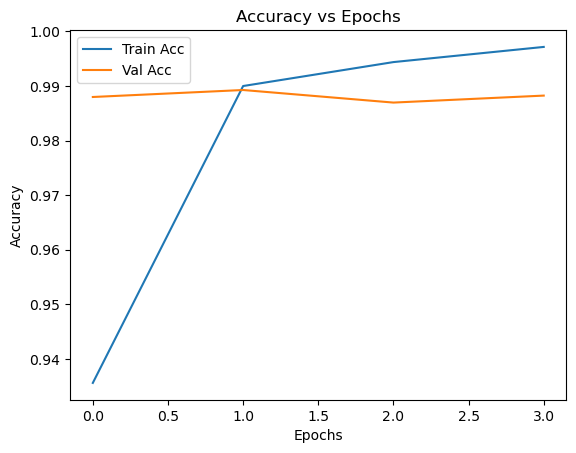

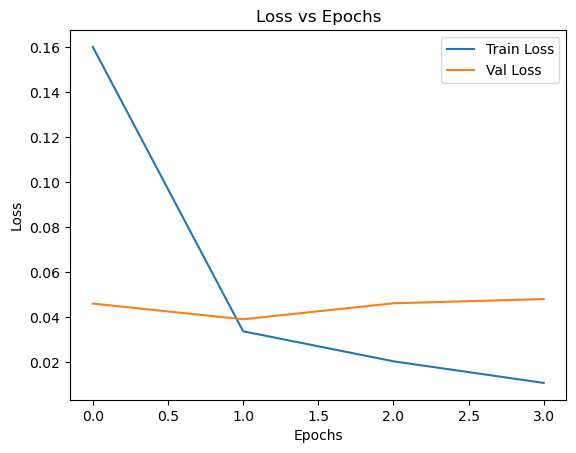

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [33]:
# Predictions
y_probs = model.predict(X_test_pad).ravel()
y_pred = (y_probs >= 0.5).astype(int)

2025-05-03 19:20:14.614896: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 440 bytes spill stores, 344 bytes spill loads

2025-05-03 19:20:14.815919: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 988 bytes spill stores, 884 bytes spill loads

2025-05-03 19:20:14.951273: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 20 bytes spill stores, 20 bytes spill loads

2025-05-03 19:20:14.998753: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 436 bytes spill stores, 344 bytes spill loads

2025-05-03 19:20:15.097783: I external/local_x

236/245 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2025-05-03 19:20:18.196778: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 20 bytes spill stores, 20 bytes spill loads

2025-05-03 19:20:18.255133: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 436 bytes spill stores, 344 bytes spill loads

2025-05-03 19:20:18.352374: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 988 bytes spill stores, 884 bytes spill loads

2025-05-03 19:20:18.423722: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_164', 8 bytes spill stores, 8 bytes spill loads

2025-05-03 19:20:18.511508: I external/local_xla

245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


In [34]:
# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_probs)

# EER
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
fnr = 1 - tpr
eer_threshold = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
eer = interp1d(fpr, fnr)(eer_threshold)

print("🔍 Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"AUC:       {auc:.4f}")
print(f"EER:       {eer:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

🔍 Evaluation Metrics:
Accuracy:  0.9898
Precision: 0.9903
AUC:       0.9987
EER:       0.0108

📋 Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      3580
        Real       0.99      0.99      0.99      4240

    accuracy                           0.99      7820
   macro avg       0.99      0.99      0.99      7820
weighted avg       0.99      0.99      0.99      7820



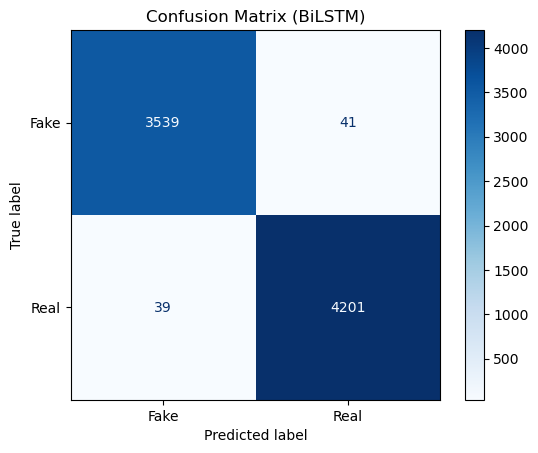

In [38]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Fake", "Real"]).plot(cmap="Blues")
plt.title("Confusion Matrix (BiLSTM)")
plt.show()


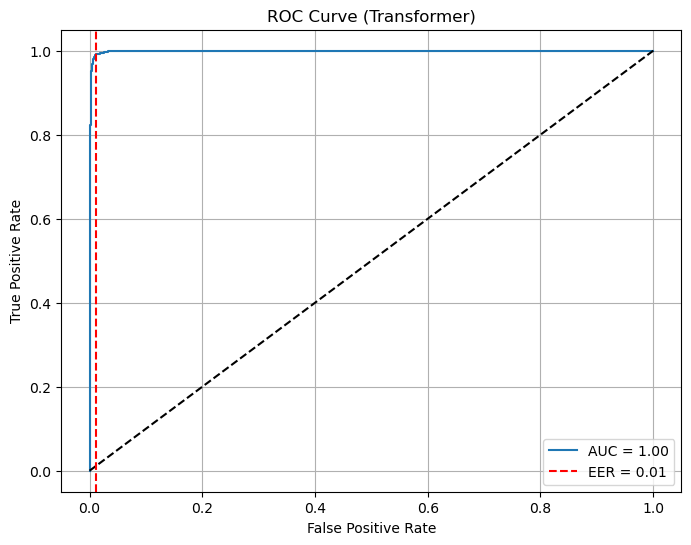

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.axvline(eer_threshold, color='red', linestyle='--', label=f"EER = {eer:.2f}")
plt.title("ROC Curve (Transformer)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()
